# March Madness and Analytics:

## Can you Predict NCAA Basketball Tournament Bids from the Massey Ratings?

In another notebook, we looked at the correlation between tournament bids for men's and women's NCAA D-1 basketball teams.  We used data for rankings that were based on the [Massey Ratings](https://www.masseyratings.com).  In this notebook we try to understand the relationship between the Massey Rating and the likelihood that a team get a tournament bid.

This process is very similar to any analytics project in  which you are trying to predict a binary outcome from a numeric variable (frequently a continuous variable).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

I downloaded Massey Ratings to the csv files `Massey_men_d1.csv` and `Massey_women_d1.csv` 
from [here](https://www.masseyratings.com/cb/ncaa-d1/ratings) for the men and
from [here](https://www.masseyratings.com/cbw/ncaa-d1/ratings) for the women. The *rating* is a continuous 
numerical variable, and it is accompanied by a *ranking* according to those values. You can read on the Massey Ratings site how they derive the ratings. In the other notebook, on Kendall's Tau, we primarily analyzed ranking. In this notebook we focus on the rating, but this entire analysis could be done using ranking as the numeric variable.

In [2]:
df_mens_ratings = pd.read_csv('Massey_men_d1.csv',usecols=['Team','Rat','Unnamed: 6'],index_col='Team')\
.rename(columns={'Rat':'Ranking','Unnamed: 6':'Massey_rating'})

df_womens_ratings = pd.read_csv('Massey_women_d1.csv',usecols=['Team','Rat','Unnamed: 6'],index_col='Team')\
.rename(columns={'Rat':'Ranking','Unnamed: 6':'Massey_rating'})

In [3]:
df_mens_ratings.sample(5).sort_values('Massey_rating')

,Ranking,Massey_rating
Team,,
Boston Univ,237,5.66
Hawaii,198,6.06
DePaul,131,6.68
Buffalo,93,7.10
Seton Hall,53,7.65


In [4]:
df_womens_ratings.sample(5).sort_values('Massey_rating')

,Ranking,Massey_rating
Team,,
MS Valley St,349,2.52
Delaware St,340,2.79
Hartford,332,3.06
Gardner Webb,289,3.74
Wofford,256,4.24


In [5]:
df_womens_field = pd.read_csv('tournament_women.csv')
df_womens_field['Tournament_bid'] = True
df_mens_field = pd.read_csv('tournament_men.csv')
df_mens_field['Tournament_bid'] = True

In [6]:
df_mens_ratings = df_mens_ratings.merge(df_mens_field,on='Team',how='outer').fillna(False)
df_womens_ratings = df_womens_ratings.merge(df_womens_field,on='Team',how='outer').fillna(False)

## How do the ratings compare between the teams with and without tournament bids?

We start by just looking at some descriptive statistics using the `groupby` and `describe` methods.

In [7]:
df_mens_ratings.groupby('Tournament_bid').Massey_rating.describe()

,count,mean,std,min,25%,50%,75%,max
Tournament_bid,,,,,,,,
False,279.0,6.033154,0.904281,3.12,5.395,5.95,6.6900,7.96
True,68.0,7.732206,0.837507,5.67,7.280,8.00,8.2325,9.75


In [8]:
df_womens_ratings.groupby('Tournament_bid').Massey_rating.describe()

,count,mean,std,min,25%,50%,75%,max
Tournament_bid,,,,,,,,
False,291.0,4.722784,1.179031,1.32,3.875,4.740,5.5450,7.66
True,64.0,6.994531,1.231917,4.53,6.070,7.195,7.7675,9.57


For the men and women we see that mean ratings between the teams getting tournament bids and those who did not are fairly well separated. For the men the means differed by 1.70 points with standard deviations under 1.0. For the women the means were a little closer with a difference of 1.27 and standard deviations in the neighborhood of 1.2.

From a stats perspective, we can conduct a t-test for independent samples. Here we see that Student's t statistic is 13.4 for the women with a corresponding p-value that is extremely small at 2.7e-23. Results for the men are similar. See the documentation at [scipy.stats.ttest_ind](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html) for details.
(I have set the keyword argument `equal_var` to `False`, but we might reasonably be able to assume `True`.)

In [9]:
from scipy.stats import ttest_ind

In [10]:
women_grouped = df_womens_ratings.groupby('Tournament_bid')

a = np.array(women_grouped.get_group(True).Massey_rating)
b = np.array(women_grouped.get_group(False).Massey_rating)

ttest_ind(a,b,axis=0,equal_var=False)

Ttest_indResult(statistic=13.459076699972298, pvalue=2.7648809292172043e-23)

In [11]:
men_grouped = df_mens_ratings.groupby('Tournament_bid')

a = np.array(men_grouped.get_group(True).Massey_rating)
b = np.array(men_grouped.get_group(False).Massey_rating)

ttest_ind(a,b,axis=0,equal_var=False)

Ttest_indResult(statistic=14.762716707049462, pvalue=1.069809698992669e-27)

### Plotting the Ratings by Group

Here we plot histograms of the subgroups.

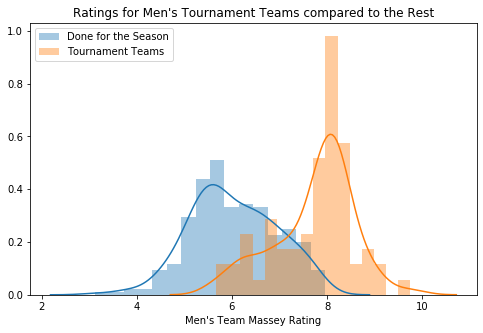

In [12]:
plt.figure(figsize=(8,5))
men_grouped.apply(lambda x: sns.distplot(x.Massey_rating,kde=True,bins=16));
plt.legend(['Done for the Season','Tournament Teams']);
plt.xlabel("Men's Team Massey Rating")
plt.title("Ratings for Men's Tournament Teams compared to the Rest");

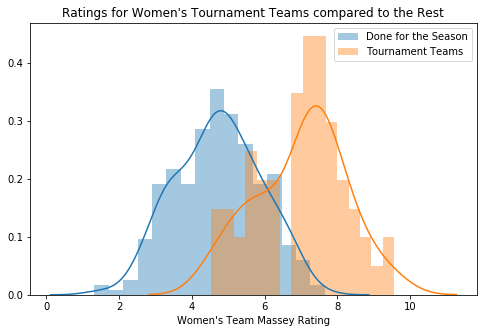

In [13]:
plt.figure(figsize=(8,5))
women_grouped.apply(lambda x: sns.distplot(x.Massey_rating,kde=True,bins=16));
plt.legend(['Done for the Season','Tournament Teams']);
plt.xlabel("Women's Team Massey Rating")
plt.title("Ratings for Women's Tournament Teams compared to the Rest");

## How can we use Massey Ratings to assess the likelihood of making the tournament?

A team's rating *should* tell us how likely they are to make the tournament. But as we see above, there is significant overlap between the teams that make it into the tournament and those that don't.  Obviously, teams that don't win their conference's automatic bid, need to be ranked high enough to get into the tournament. Teams that fall in that overlapping zone are frequently referred to as being "on the bubble".

If we were going to predict which teams made the tournament from the rating alone, we would try to choose some middle value, predicting that any team above that threshold is likely to get a bid, and teams below the threshold are likely to not get a bid.  How should we choose that threshold?

### Using ROC Curves

We treat the rating as an independent variable and use it to set a threshold value for the rating as a proxy for getting into the tournament. A team with a rating above the threshold is a "positive" test case. If the team also made the tournament, it is a *true positive*. Otherwise it is a *false positive* (sometimes called a *false alarm* for historical reasons). 

For example consider a rating of 7.7 for the women. That's close to the 75th percentile for the women's tournament field and higher than the maximum rating for the non-tournament teams. So we have a true positive rate of about 0.25. Since there are no false positives, the false positive rate is 0. Visually, the true positive rate (TPR) is the area under the orange curve to the right of the threshold value, and the false positive rate (FPR) is the area under the blue curve to the right of the threshold value. Consider the threshold of 6.0. Now we have about 75% of the tournament field above 6 (true positive rate), and slightly less than 25% of the non-tournament teams (false positives). For a threshold as low as 4.7, we are capturing nearly 100% of tournament teams but only 50% of non-tournament teams.

**The ROC Curve plots the true positive rate against the false positive rate.**  As the threshold rating falls from the maximum of 9.57 to the minimum of 1.32, the TPR and FPR both rise from 0 to 1. So the ROC Curve increases monotonically from (0,0) to (1,1).

Note that if there were no difference between the two distributions, then the true positive rate and the false positive rate would be roughly same for every value of the rating, and the ROC curve would coincide with the diagonal line joining (0,0) to (1,1).

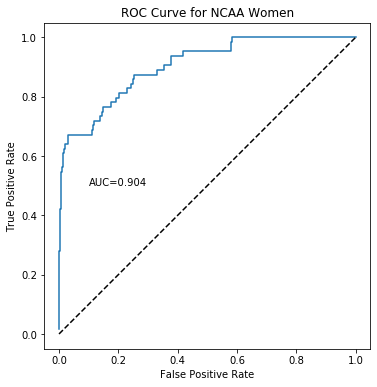

In [14]:
# ranks are just the sequence from 1 to 348
df_womens_ratings.sort_values('Massey_rating',ascending=False,inplace=True)
ratings = np.array(df_womens_ratings.Massey_rating)

# Define the true/false positives and true/false positive rates. 
tp = np.array(df_womens_ratings.Tournament_bid.cumsum())
fp = np.array((1 - df_womens_ratings.Tournament_bid).cumsum())
tpr = tp/df_womens_ratings.Tournament_bid.sum()
fpr = fp/(1 - df_womens_ratings.Tournament_bid).sum()

# Now we plot the TPR against the FPR to get the ROC curve.
plt.figure(figsize=(6,6))
plt.plot(fpr,tpr);

# Add the diagonal line and ...
plt.plot(fpr,fpr,'--k');

# We compute the AUC we use "midpoint rule"
# However, the ROC curve consists of horizontal and vertical 
# line segments; so we could have used either right or left endpoints.
y = (tpr[:-1] + tpr[1:])/2
delta_x = np.diff(fpr)
auc = (y*delta_x).sum()
plt.text(.1, .5,f'AUC={auc:.3f}')

# Add labels and title.
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for NCAA Women')
plt.axis('square');

What is the best threshold to set? Or at least a good threshold...

The Youden Index is the point at which the ROC curve is the highest above the diagonal. If the ROC curve is smooth, it is also the point where the True Positive Rate equals the False Positive Rate. I.e. the slope of the tangent line is parallel to the diagonal. So this is the point at which changing the threshold by a small amount admits equal numbers of true and false positives.  This may be a good choice for setting a threshold for using the ranking for predicting who makes the tournament.

We can compute the value of the Youden Index and find the corresponding values of the Massey rating as well as the corresponding TPR and FPR.

Why might one choose a different threshold? One needs to assess the *recall* and *precision* values and consider your objectives. Is recall more important than precision? Or vice versa?  The [F-score](https://en.wikipedia.org/wiki/F-score) attempts to balance recall and precision. It is the harmonic mean of the two metrics. The F-beta score is a weighted harmonic mean which allows one to put more or less weight on recall relative to precision.

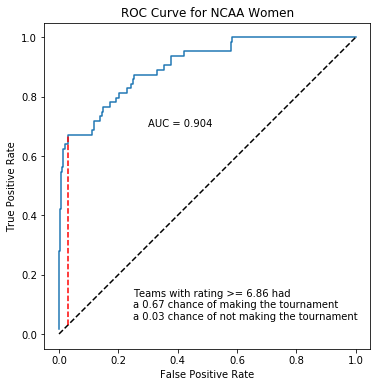

In [15]:
# ranks are just the sequence from 1 to 348
df_womens_ratings.sort_values('Massey_rating',ascending=False,inplace=True)
ratings = np.array(df_womens_ratings.Massey_rating)

# Define the true/false positives and true/false positive rates. 
tp = np.array(df_womens_ratings.Tournament_bid.cumsum())
fp = np.array((1 - df_womens_ratings.Tournament_bid).cumsum())
tpr = tp/df_womens_ratings.Tournament_bid.sum()
fpr = fp/(1 - df_womens_ratings.Tournament_bid).sum()

# The Youden index is the point where the ROC curve is highest above
# the diagonal.
youden = tpr - fpr
youden_idx = list(youden).index(youden.max())
tpr_youden = tpr[youden_idx]
fpr_youden = fpr[youden_idx]
rating_youden = ratings[youden_idx]

# Now we plot the TPR against the FPR to get the ROC curve.
plt.figure(figsize=(6,6))
plt.plot(fpr,tpr);

# Add the diagonal line and ...
plt.plot(fpr,fpr,'--k');

# drop a vertical from the ROC curve at the Youden index.
plt.plot([fpr_youden,fpr_youden],[fpr_youden,tpr_youden],'--r');

# We compute the AUC we use "midpoint rule"
# However, the ROC curve consists of horizontal and vertical 
# line segments; so we could have used either right or left endpoints.
y = (tpr[:-1] + tpr[1:])/2
delta_x = np.diff(fpr)
auc = (y*delta_x).sum()

# Annotate the plot with the AUC and some info about the Youden index.
plt.text(.3, .7,f'AUC = {auc:.3f}')
plt.text(0.25,0.05, f'Teams with rating >= {rating_youden:.2f} had\n' +\
         f'a {tpr_youden:.2f} chance of making the tournament\n' + \
         f'a {fpr_youden:.2f} chance of not making the tournament')

# Add labels and title.
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for NCAA Women')
plt.axis('square');

Let's consider other metrics: recall, precision, and accuracy.

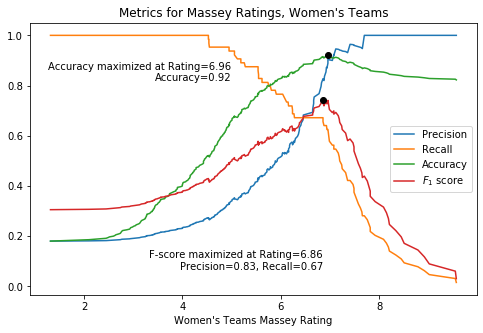

In [16]:
# Compute the false/true negatives.
fn = df_womens_ratings.Tournament_bid.sum()- tp
tn = (1 - df_womens_ratings.Tournament_bid).sum() - fp

# We use the previously and newly computed values to compute 
# additional metrics:
precision = tp/(tp + fp)
recall = tp/(tp + fn)
accuracy = (tp + tn)/(tp + fp + tn + fn)
f_score = 2/((1/(precision + 1e-6)) + (1/(recall + 1e-6)))

# Find the place where the F-score and accuracy are maximized.
f_idx = list(f_score).index(f_score.max())
a_idx = list(accuracy).index(accuracy.max())

# Plot metrics.
plt.figure(figsize=(8,5))
plt.plot(ratings,precision,label='Precision')
plt.plot(ratings,recall,label='Recall')
plt.plot(ratings,accuracy,label='Accuracy')
plt.plot(ratings,f_score,label='$F_1$ score')

# Mark the maximum F-score, accuracy
plt.plot(ratings[f_idx],f_score[f_idx],'ok')
plt.plot(ratings[a_idx],accuracy[a_idx],'ok')

# Annotate the plots
plt.text(ratings[f_idx],0.02,f'F-score maximized at Rating={ratings[f_idx]:.2f}\n' +
        f'Precision={precision[f_idx]:.2f}, ' +
        f'Recall={recall[f_idx]:.2f}\n',
        ha='right')
plt.text(5, -0.15 + accuracy[a_idx],f'Accuracy maximized at Rating={ratings[a_idx]:.2f}\n' +
        f'Accuracy={accuracy[a_idx]:.2f}\n',
        ha='right')


# Label the plot.
plt.legend(loc=5);
plt.xlabel("Women's Teams Massey Rating");
plt.title("Metrics for Massey Ratings, Women's Teams");

We note that the Youden Index also maximizes the F-score. A slightly higher rating maximizes accuracy.
### Men's Ratings
We repeat for the men's teams what we did for the women's teams.

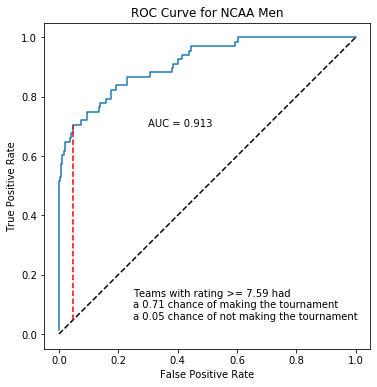

In [17]:
# ranks are just the sequence from 1 to 348
df_mens_ratings.sort_values('Massey_rating',ascending=False,inplace=True)
ratings = np.array(df_mens_ratings.Massey_rating)

# Define the true/false positives and true/false positive rates. 
tp = np.array(df_mens_ratings.Tournament_bid.cumsum())
fp = np.array((1 - df_mens_ratings.Tournament_bid).cumsum())
tpr = tp/df_mens_ratings.Tournament_bid.sum()
fpr = fp/(1 - df_mens_ratings.Tournament_bid).sum()

# The Youden index is the point where the ROC curve is highest above
# the diagonal.
youden = tpr - fpr
youden_idx = list(youden).index(youden.max())
tpr_youden = tpr[youden_idx]
fpr_youden = fpr[youden_idx]
rating_youden = ratings[youden_idx]

# Now we plot the TPR against the FPR to get the ROC curve.
plt.figure(figsize=(6,6))
plt.plot(fpr,tpr);

# Add the diagonal line and ...
plt.plot(fpr,fpr,'--k');

# drop a vertical from the ROC curve at the Youden index.
plt.plot([fpr_youden,fpr_youden],[fpr_youden,tpr_youden],'--r');

# We compute the AUC we use "midpoint rule"
# However, the ROC curve consists of horizontal and vertical 
# line segments; so we could have used either right or left endpoints.
y = (tpr[:-1] + tpr[1:])/2
delta_x = np.diff(fpr)
auc = (y*delta_x).sum()

# Annotate the plot with the AUC and some info about the Youden index.
plt.text(.3, .7,f'AUC = {auc:.3f}')
plt.text(0.25,0.05, f'Teams with rating >= {rating_youden:.2f} had\n' +\
         f'a {tpr_youden:.2f} chance of making the tournament\n' + \
         f'a {fpr_youden:.2f} chance of not making the tournament')

# Add labels and title.
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for NCAA Men')
plt.axis('square');

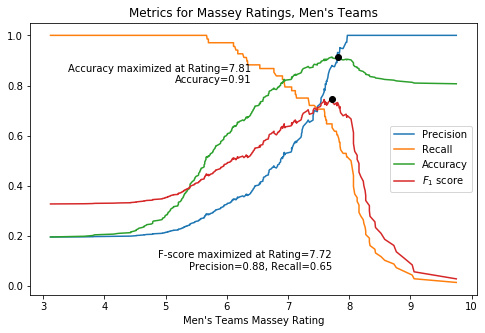

In [18]:
# Compute the false/true negatives.
fn = df_mens_ratings.Tournament_bid.sum()- tp
tn = (1 - df_mens_ratings.Tournament_bid).sum() - fp

# We use the previously and newly computed values to compute 
# additional metrics:
precision = tp/(tp + fp)
recall = tp/(tp + fn)
accuracy = (tp + tn)/(tp + fp + tn + fn)
f_score = 2/((1/(precision + 1e-6)) + (1/(recall + 1e-6)))

# Find the place where the F-score and accuracy are maximized.
f_idx = list(f_score).index(f_score.max())
a_idx = list(accuracy).index(accuracy.max())

# Plot metrics.
plt.figure(figsize=(8,5))
plt.plot(ratings,precision,label='Precision')
plt.plot(ratings,recall,label='Recall')
plt.plot(ratings,accuracy,label='Accuracy')
plt.plot(ratings,f_score,label='$F_1$ score')

# Mark the maximum F-score, accuracy
plt.plot(ratings[f_idx],f_score[f_idx],'ok')
plt.plot(ratings[a_idx],accuracy[a_idx],'ok')

# Annotate the plots
plt.text(ratings[f_idx],0.02,f'F-score maximized at Rating={ratings[f_idx]:.2f}\n' +
        f'Precision={precision[f_idx]:.2f}, ' +
        f'Recall={recall[f_idx]:.2f}\n',
        ha='right')
plt.text(6.4, -0.15 + accuracy[a_idx],f'Accuracy maximized at Rating={ratings[a_idx]:.2f}\n' +
        f'Accuracy={accuracy[a_idx]:.2f}\n',
        ha='right')


# Label the plot.
plt.legend(loc=5);
plt.xlabel("Men's Teams Massey Rating");
plt.title("Metrics for Massey Ratings, Men's Teams");

For the men, the rating that maximizes the F-score (7.72) is slightly higher than the Youden Index (7.59), and the rating that maximizes accuracy (7.81) is higher yet.